# Требуется проверить гипотезу о применимости модели RNN и сравнить её с моделью прямого распространения (MLP) для предсказания значений временных рядов.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import os
import struct

Создадим синусоидальный временной ряд с добавлением небольшого шума

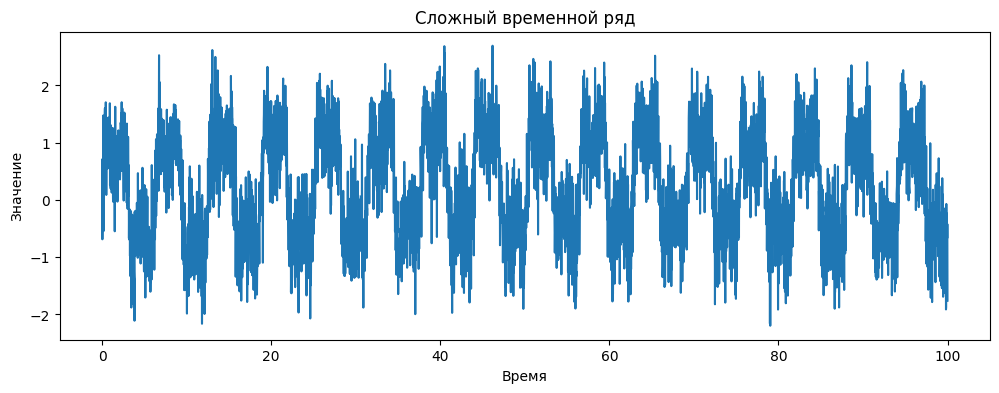

In [11]:
# Параметры
TIME_STEPS = 5000
FREQUENCIES = [1, 3, 5]
AMPLITUDES = [1, 0.5, 0.2]
NOISE = 0.5
TREND = 0.001 # линейный тренд
SEASONAL_AMPLITUDE = 0.3
SEASONAL_PERIOD = 200
N = 50 # кол-во пред значений для предсказания следующего

# Генерация временного ряда
x = np.linspace(0, 100, TIME_STEPS)
y = np.zeros(TIME_STEPS)

y += TREND * x
y += SEASONAL_AMPLITUDE * np.sin((2 * np.pi / SEASONAL_PERIOD) * x)
y += NOISE * np.random.randn(TIME_STEPS)
for freq, amp in zip(FREQUENCIES, AMPLITUDES):
    y += amp * np.sin(freq * x)

plt.figure(figsize=(12, 4))
plt.plot(x, y)
plt.title('Сложный временной ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

 Функция для формирования обучающих выборок

In [12]:
def create_dataset(series, N):
    X, y = [], []
    for i in range(len(series) - N):
        X.append(series[i:i+N])
        y.append(series[i+N])
    return np.array(X), np.array(y)

X, y = create_dataset(y, N)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Масштабирование
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

Обучение MLP для предсказания на основе N предыдущих

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3355 - val_loss: 0.1157
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1117 - val_loss: 0.0857
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0858 - val_loss: 0.0704
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0704 - val_loss: 0.0643
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0624 - val_loss: 0.0547
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - val_loss: 0.0492
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - val_loss: 0.0458
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457 - val_loss: 0.0410
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0423 - val_loss: 0.0379
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390 - val_loss: 0.0351
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0365 - val_loss: 0.0325
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

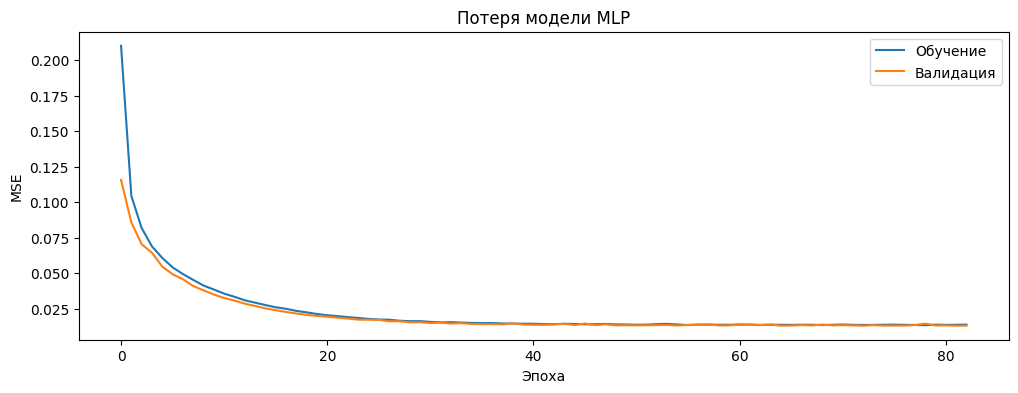

In [16]:
from tensorflow.keras.layers import Dropout # чтоб не переобучить

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(N,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse')
from tensorflow.keras.callbacks import EarlyStopping # во время остановиться

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_mlp = mlp_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.plot(history_mlp.history['loss'], label='Обучение')
plt.plot(history_mlp.history['val_loss'], label='Валидация')
plt.title('Потеря модели MLP')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.show()

Обучение RNN для той же задачи

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.3382 - val_loss: 0.0851
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1145 - val_loss: 0.0785
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0980 - val_loss: 0.0755
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0873 - val_loss: 0.0716
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0811 - val_loss: 0.0669
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0753 - val_loss: 0.0642
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0706 - val_loss: 0.0606
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0664 - val_loss: 0.0574
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0623 - val_loss: 0.0545
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0582 - val_loss: 0.0531
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0552 - val_loss: 0.0489
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

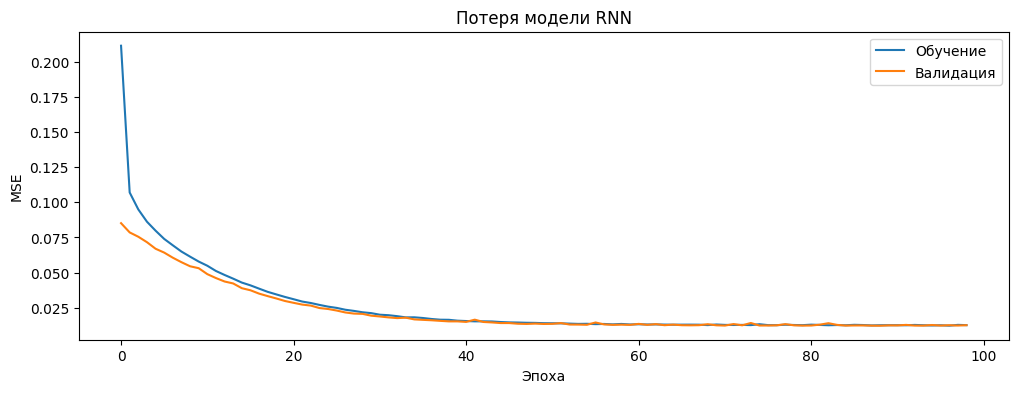

In [17]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

from tensorflow.keras.regularizers import l2 # регуляризация

rnn_model = Sequential([
    SimpleRNN(100, activation='tanh', return_sequences=True, 
              input_shape=(N, 1), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    SimpleRNN(50, activation='tanh', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rnn_model.compile(optimizer='adam', loss='mse')
history_rnn = rnn_model.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_rnn, y_test),
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.plot(history_rnn.history['loss'], label='Обучение')
plt.plot(history_rnn.history['val_loss'], label='Валидация')
plt.title('Потеря модели RNN')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.show()

Оцениваем производительность на тестовой выборке

In [18]:
y_pred_mlp = mlp_model.predict(X_test)
y_pred_rnn = rnn_model.predict(X_test_rnn)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_mlp_inv = scaler.inverse_transform(y_pred_mlp)
y_pred_rnn_inv = scaler.inverse_transform(y_pred_rnn)

mse_mlp = mean_squared_error(y_test_inv, y_pred_mlp_inv)
mse_rnn = mean_squared_error(y_test_inv, y_pred_rnn_inv)

print(f'MSE модели MLP: {mse_mlp:.4f}')
print(f'MSE модели RNN: {mse_rnn:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
MSE модели MLP: 0.0700
MSE модели RNN: 0.0723


Сравним реальные значения с предсказанными

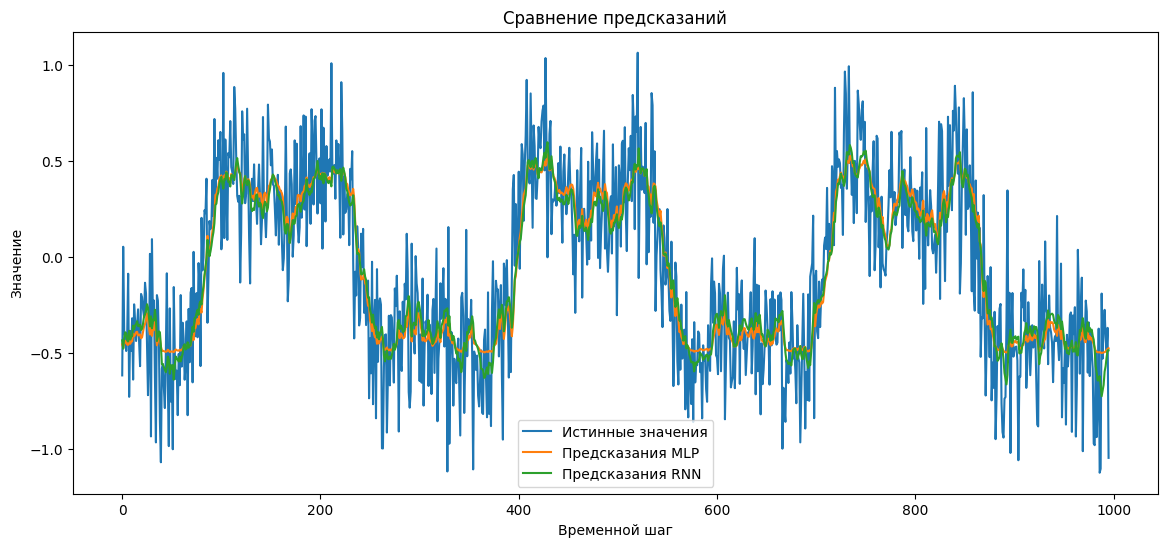

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Истинные значения')
plt.plot(y_pred_mlp_inv, label='Предсказания MLP')
plt.plot(y_pred_rnn_inv, label='Предсказания RNN')
plt.title('Сравнение предсказаний')
plt.xlabel('Временной шаг')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Итог

Из полученных результатов можно сказать, что RNN показывает лучшее качество предсказания временного ряда по сравнению с MLP, хотя и обучается значительно дольше, так же обе модели не могут захватить такой шум. Гипотеза о применении RNN для задач предсказания значений временных рядов можно считать подтвержденной, из-за способности RNN учитывать временные зависимости в данных.